In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [45]:
transform_train = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((-0.4948, -0.4858, -0.4136), (1.3125, 1.3154, 1.2739)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((-0.4948, -0.4858, -0.4136), (1.3125, 1.3154, 1.2739)),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=14)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=14)

Files already downloaded and verified
Files already downloaded and verified


In [46]:
np.unique(np.array(trainset.targets),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [47]:
np.unique(np.array(testset.targets),return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [48]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [49]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet architecture
class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
            super(ResNet, self).__init__()
            self.in_planes = C[0]
            self.block = BasicBlock
            self.N = N                # No. of Residual Layers
            self.B = B                # No. of Residual Blocks in Residual Layer i
            self.C = C                # No. of channels in Residual Layer i
            self.F = F                # Conv. kernel size in Residual Layer i
            self.K = K                # Skip connection kernel size in Residual Layer i
            self.P = P                # Average pool kernel size
            self.layers = []          # layers container
            self.S = [2] * N          # strides for layers
            self.S[0] = 1
    
            # Output Liner layer input dimension
            self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))
    
            # Print Model Config
            print("\n\nModel Config: "
                "\n-------------------------------------"
                "\nN (# Layers)\t:",self.N,
                "\nB (# Blocks)\t:",self.B,
                "\nC (# Channels)\t:",C,
                "\nF (Conv Kernel)\t:",F,
                "\nK (Skip Kernel)\t:",K,
                "\nP (Pool Kernel)\t:",P,)
    
            self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(C[0])
            for i in range(N): 
                exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                    .format(i+1,i,i,i,i,i))
                exec("self.layers.append(self.layer{})".format(i+1))
            self.linear = nn.Linear(self.outLayerInSize, num_classes)
            self.initialize_weights()
            
    
    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        for layer in self.layers:
            out = layer(out)
        out = F.avg_pool2d(out, self.P)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            
    
    # N: : # Residual Layers
    # Bi : # Residual blocks in Residual Layer i
    # Ci : # channels in Residual Layer i
    # Fi : Conv. kernel size in Residual Layer i
    # Ki : Skip connection kernel size in Residual Layer i
    # P  : Average pool kernel size


def Final_Model():

    B=[3,3,2,3]
    C=[136,100,188,204]
    F=[3,3,3,3]
    K=[1,1,1,1]
    P=4
    N=len(B)

    return ResNet(N, B, C, F, K, P)


In [50]:
model = Final_Model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=1e-1, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [136, 100, 188, 204] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


In [51]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

4997074

Train Epoch: 1 [0/50000 (0%)]	Loss: 6.514163
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.296749
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.189374
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.887171

Test set: Average loss: 2.0011, Accuracy: 2873/10000 (29%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.010450
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.657342
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.774033
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.599429

Test set: Average loss: 1.9019, Accuracy: 3691/10000 (37%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.636792
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.546430
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.567377
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.516304

Test set: Average loss: 1.6577, Accuracy: 4870/10000 (49%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.447250
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.416443
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.510602
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.421682

Test set: Average loss: 1.2159, Accu

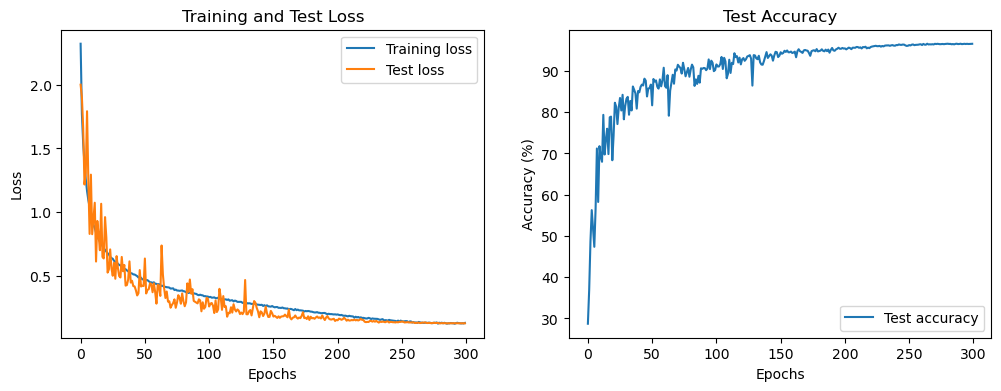

In [52]:
train_losses = []
test_losses = []
accuracies = []

def train(model, device, train_loader, criterion, optimizer, epoch, train_losses):
    model = model.to(device)
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.size(0)
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    average_loss = total_loss / len(train_loader.dataset)
    train_losses.append(average_loss)

def test(model, device, test_loader, criterion, test_losses, accuracies):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

def plot_metrics(train_losses, test_losses, accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Test loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Test accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

epochs = 300  # Update the total number of epochs if needed
for epoch in range(1, epochs + 1):
    train(model, device, trainloader, criterion, optimizer, epoch, train_losses)
    test(model, device, testloader, criterion, test_losses, accuracies)
    scheduler.step()

    # Save the model checkpoint every 10 epochs starting from 170th epoch
    if epoch >= 170 and epoch % 10 == 0:
        torch.save(model.state_dict(), f'S-last-{epoch}.pt')

plot_metrics(train_losses, test_losses, accuracies)

In [53]:
torch.save(model,"SLast.pt")

In [54]:
pd.DataFrame(test_losses).to_csv("SLast_test_loss_array")
pd.DataFrame(train_losses).to_csv("SLast_train_loss_array")
pd.DataFrame(accuracies).to_csv("SLast_accuracy_array")

In [55]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict1 = pickle.load(fo, encoding='bytes')
    return dict1
def model_test(model, data_path):
    dict = unpickle(data_path)
    data_test = dict[b'data']
    model.eval()
    pred = []

    for i in range(data_test.shape[0]):
        # Reshape from (3072,) to (3, 32, 32) for an RGB image
        img_rgb = data_test[i].reshape(3, 32, 32).transpose((1, 2, 0))

        # Convert to PIL image
        img_pil = Image.fromarray(img_rgb)

        # Apply the transformation
        img_tensor = transform_test(img_pil)

        # Add a batch dimension and send the image to the model
        img_tensor = img_tensor.unsqueeze(0).cuda()
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            pred.extend(predicted.cpu().numpy())

    return pred

In [56]:
pred = model_test(model, "cifar_test_nolabels.pkl")
np.unique(pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 879,  999,  951, 1066,  959, 1096,  941,  988, 1065, 1056]))

In [57]:
import pandas as pd
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict1 = pickle.load(fo, encoding='bytes')
    return dict1

dict = unpickle("cifar_test_nolabels.pkl")
df = pd.DataFrame({"ID" : dict[b'ids'], "Labels" : pred})

In [58]:
df.to_csv("SLast.csv", index = False)

In [59]:
pd.read_csv("SLast.csv")['Labels'].value_counts()

Labels
5    1096
3    1066
8    1065
9    1056
1     999
7     988
4     959
2     951
6     941
0     879
Name: count, dtype: int64